In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch_lightning
!pip install torchvision

In [ ]:
import numpy as np
# import pandas as pd
import cv2 as cv 
import os
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
import pytorch_lightning as pl
import torch
import random
import itertools

!pwd
%cd drive/MyDrive/summer_school_sdu/medical-robot-repo/autoencoder/
#%cd .. #for computer
!pwd

from src.networks.segmentationUNet import SegmentationAE
from src.data.segmentation_dataset2 import Data, label_img_to_rgb
from src.util.visualization import visualizer
from src.util.save_model import save_model 

#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content
/content/drive/.shortcut-targets-by-id/1nkSBip8QBWLlGCjlBgIVPho2kMqJZzYz/summer_school_sdu/medical-robot-repo/autoencoder
/content/drive/.shortcut-targets-by-id/1nkSBip8QBWLlGCjlBgIVPho2kMqJZzYz/summer_school_sdu/medical-robot-repo/autoencoder


Define the paths of the stored models and load the model


In [ ]:
left_hand = "/content/drive/MyDrive/summer_school_sdu/medical-robot-repo/results/segmentation_nn.model"

In [ ]:
model = torch.load(left_hand)

In [ ]:
train_image_path = '/content/drive/MyDrive/summer_school_sdu/ROPCA_Vision/all_split/train.txt'
val_image_path = '/content/drive/MyDrive/summer_school_sdu/ROPCA_Vision/all_split/val.txt'
test_image_path = '/content/drive/MyDrive/summer_school_sdu/ROPCA_Vision/all_split/test.txt'

# train_image_path = '/media/jagatpreet/Data/summer_school/medical-robot/ROPCA_Vision/train1.txt'
# val_image_path = '../ROPCA_Vision/val1.txt'
# test_image_path = '../ROPCA_Vision/test1.txt'

train_data = Data(train_image_path)
val_data = Data(val_image_path)
test_data = Data(test_image_path)

print(train_data)
print(val_data)
print(test_data)

<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>
<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>
<module 'posixpath' from '/usr/lib/python3.7/posixpath.py'>


In [ ]:
print(len(train_data))

148


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


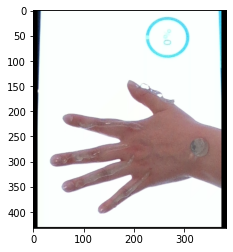

In [ ]:
num_example_imgs = 4
model.to(device)
for i, (img, target) in enumerate(train_data[:4]):
    inputs = img.unsqueeze(0)
    inputs = inputs.to(device)

    outputs = model.forward(inputs.to(device))
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()

    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
plt.imshow(img.transpose(1, 2, 0))
print(target)

In [ ]:
for i in range(10):
  if i in target:
    print(i)



0
1
2
3
4


In [ ]:
def create_mask(img):
  pink_mask, red_mask, green_mask, yellow_mask = np.zeros((432, 384)), np.zeros((432, 384)), np.zeros((432, 384)), np.zeros((432, 384))

  pink = [250, 50, 183]
  red = [236, 28, 36]
  green = [14, 209, 69]
  yellow = [255,242,0]

  for i in range(432):
    for j in range(384):
      if (img[i, j] == pink).all():
        pink_mask[i,j] = 1
      elif (img[i, j] == red).all():
        red_mask[i,j] = 1
      elif (img[i, j] == green).all():
        green_mask[i,j] = 1
      elif (img[i, j] == yellow).all():
        yellow_mask[i,j] = 1
  return pink_mask, red_mask, green_mask, yellow_mask


def return_iou(img1, img2):
  pink_mask1, red_mask1, green_mask1, yellow_mask1 = create_mask(img1)
  pink_mask2, red_mask2, green_mask2, yellow_mask2 = create_mask(img2)

  def calculate_iou(mask1, mask2):
    intersection = sum(sum((mask1 == mask2) & (mask1 == 1)))
    union = sum(sum((mask1 == 1) | (mask2 == 1)))
    return intersection / union

  result = np.array([calculate_iou(pink_mask1, pink_mask2), calculate_iou(red_mask1, red_mask2),
                     calculate_iou(green_mask1, green_mask2), calculate_iou(yellow_mask1, yellow_mask2)])
  return result

return_iou(label_img_to_rgb(target), label_img_to_rgb(pred))


array([0.        , 0.64918654, 0.33501259, 0.47907182])

In [ ]:
create_mask(target)[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

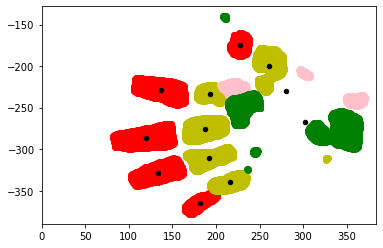

{'green_landing': array([[267.71524413, 301.7778606 ]]),
 'pink_landing': array([[229.63494318, 280.42897727]]),
 'red_landing': array([[286.618125  , 119.46625   ],
        [174.44071146, 227.63043478],
        [364.33005894, 181.55992141],
        [328.22814321, 133.39383847],
        [228.98218263, 137.05270973]]),
 'yellow_landing': array([[275.4150772 , 187.15622162],
        [200.01007326, 260.60164835],
        [340.12024353, 216.22070015],
        [310.69749728, 191.85092492],
        [233.77376426, 193.24144487]])}

In [ ]:
def find_landing_points(img, increible):
  from sklearn.cluster import KMeans

  colored_masks = create_mask(img)
  
  pink_mask, red_mask, green_mask, yellow_mask = colored_masks[0], colored_masks[1], colored_masks[2], colored_masks[3]
  pink_xy, red_xy, green_xy, yellow_xy = [], [], [], []

  for i in range(432):
      for j in range(384):
        if pink_mask[i,j] == 1:
          pink_xy.append([i,j])
        elif red_mask[i,j] == 1:
          red_xy.append([i,j])
        elif green_mask[i,j] == 1:
          green_xy.append([i,j])
        elif yellow_mask[i,j] == 1:
          yellow_xy.append([i,j])
  pink_xy, red_xy, green_xy, yellow_xy = np.array(pink_xy), np.array(red_xy), np.array(green_xy), np.array(yellow_xy)

  def sort_centroids(my_list):
    #sorts centroids by y-values to order the joints
    return sorted(my_list , key=lambda k: (k[1], k[0]))

  #red joints
  red_kmeans = KMeans(n_clusters=5, random_state=0)
  red_label = red_kmeans.fit_predict(red_xy)
  red_labels = np.unique(red_label)
  red_centroids = red_kmeans.cluster_centers_

  # print('not', red_centroids)
  # print('sorted', sort_centroids(red_centroids))

  #yellow joints
  yellow_kmeans = KMeans(n_clusters=5, random_state=0)
  yellow_label = yellow_kmeans.fit_predict(yellow_xy)
  yellow_labels = np.unique(yellow_label)
  yellow_centroids = yellow_kmeans.cluster_centers_

  #pink only has 1 joint
  pink_kmeans = KMeans(n_clusters=1, random_state=0)
  pink_label = pink_kmeans.fit_predict(pink_xy)
  pink_centroids = pink_kmeans.cluster_centers_

  #green only has 1 join
  green_kmeans = KMeans(n_clusters=1, random_state=0)
  green_label = green_kmeans.fit_predict(green_xy)
  green_centroids = green_kmeans.cluster_centers_

  #plotting the results:
  for i in red_labels:
      plt.scatter(red_xy[red_label == i , 1] , -red_xy[red_label == i , 0] , label = i, color = 'r')
      plt.scatter(yellow_xy[yellow_label == i , 1] , -yellow_xy[yellow_label == i , 0] , label = i, color = 'y')
  
  plt.scatter(pink_xy[:, 1] , -pink_xy[:, 0], color = 'pink')
  plt.scatter(green_xy[:, 1] , -green_xy[:, 0], color = 'green')

  plt.scatter(red_centroids[:,1] , -red_centroids[:,0] , s = 20, color = 'k')
  plt.scatter(yellow_centroids[:,1] , -yellow_centroids[:,0] , s = 20, color = 'k')
  plt.scatter(pink_centroids[:,1] , -pink_centroids[:,0] , s = 20, color = 'k')
  plt.scatter(green_centroids[:,1] , -green_centroids[:,0] , s = 20, color = 'k')

  plt.xlim(0, 384)
  # plt.ylim(-200, 0)
  # plt.legend()
  plt.show()
  plt.savefig('centroids'+'.png')

  landing_points = {'pink_landing': pink_centroids, 'red_landing': red_centroids, 'green_landing': green_centroids, 'yellow_landing': yellow_centroids}
  return landing_points

find_landing_points(label_img_to_rgb(pred))

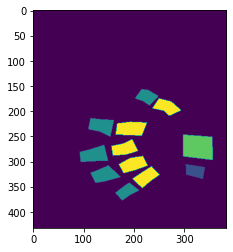

In [ ]:
plt.imshow(target)

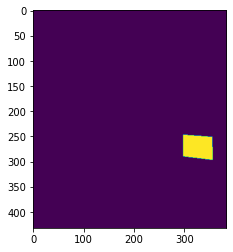

In [ ]:
a = create_mask(label_img_to_rgb(target))[2]
# b = create_mask(label_img_to_rgb(pred))[1]
plt.imshow(a)

In [ ]:
# plt.imshow(label_img_to_rgb(pred))

In [ ]:
# plt.imshow(b)

In [ ]:
# plt.imshow(target)
# plt.imshow(pred)
# if 4 in pred:
#   print(True)

In [ ]:
plt.imread(target)

ValueError: ignored